## Import Required libraries

In [151]:
%matplotlib inline

import numpy as np 
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore')
import seaborn as sns

from statsmodels.tsa.stattools import adfuller 
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.vector_ar.vecm import coint_johansen

from statsmodels.distributions.empirical_distribution import ECDF
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf,pacf

from pylab import rcParams
from sklearn.preprocessing import MinMaxScaler

## Read the data files

In [152]:
# Import the train and the store data
train = pd.read_csv('C:\\Users\\Suresh_Sridharan\\Downloads\\train.csv',parse_dates=[2],infer_datetime_format=1)
store = pd.read_csv('C:\\Users\\Suresh_Sridharan\\Downloads\\store.csv')

In [153]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype         
---  ------         --------------    -----         
 0   Store          1017209 non-null  int64         
 1   DayOfWeek      1017209 non-null  int64         
 2   Date           1017209 non-null  datetime64[ns]
 3   Sales          1017209 non-null  int64         
 4   Customers      1017209 non-null  int64         
 5   Open           1017209 non-null  int64         
 6   Promo          1017209 non-null  int64         
 7   StateHoliday   1017209 non-null  object        
 8   SchoolHoliday  1017209 non-null  int64         
dtypes: datetime64[ns](1), int64(7), object(1)
memory usage: 69.8+ MB


In [154]:
train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [155]:
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [156]:
# Check if we have data as sales zero other than a Sunday
train[train.Sales<1]

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
291,292,5,2015-07-31,0,0,0,1,0,1
875,876,5,2015-07-31,0,0,0,1,0,1
1406,292,4,2015-07-30,0,0,0,1,0,1
1990,876,4,2015-07-30,0,0,0,1,0,1
2521,292,3,2015-07-29,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1
1017205,1112,2,2013-01-01,0,0,0,0,a,1
1017206,1113,2,2013-01-01,0,0,0,0,a,1
1017207,1114,2,2013-01-01,0,0,0,0,a,1


In [157]:
train[train.StateHoliday=='a'] # we have sales figures on a State Holiday too

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
63555,1,4,2015-06-04,0,0,0,1,a,0
63557,3,4,2015-06-04,0,0,0,1,a,0
63559,5,4,2015-06-04,5807,625,1,1,a,0
63560,6,4,2015-06-04,5749,614,1,1,a,0
63563,9,4,2015-06-04,0,0,0,1,a,0
...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1
1017205,1112,2,2013-01-01,0,0,0,0,a,1
1017206,1113,2,2013-01-01,0,0,0,0,a,1
1017207,1114,2,2013-01-01,0,0,0,0,a,1


In [158]:
#Stores to be forecast
store_list = [1,3,8,9,13,25,29,31,46]

In [159]:
# We are interested in Analysing / Building models for the stores in store list. So subsecting the data for those stores only
sub_train = train[train.Store.isin(store_list)]
sub_store = store[store.Store.isin(store_list)]

In [160]:
sub_train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
7,8,5,2015-07-31,8492,833,1,1,0,1
8,9,5,2015-07-31,8565,687,1,1,0,1
12,13,5,2015-07-31,8821,568,1,1,0,0


In [161]:
sub_store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
7,8,a,a,7520.0,10.0,2014.0,0,NaN,NaN,NaN
8,9,a,c,2030.0,8.0,2000.0,0,NaN,NaN,NaN
12,13,d,a,310.0,NaN,NaN,1,45.0,2009.0,"Feb,May,Aug,Nov"


In [162]:
display(sub_train.isnull().sum(),sub_store.isnull().sum())

Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

Store                        0
StoreType                    0
Assortment                   0
CompetitionDistance          0
CompetitionOpenSinceMonth    2
CompetitionOpenSinceYear     2
Promo2                       0
Promo2SinceWeek              6
Promo2SinceYear              6
PromoInterval                6
dtype: int64

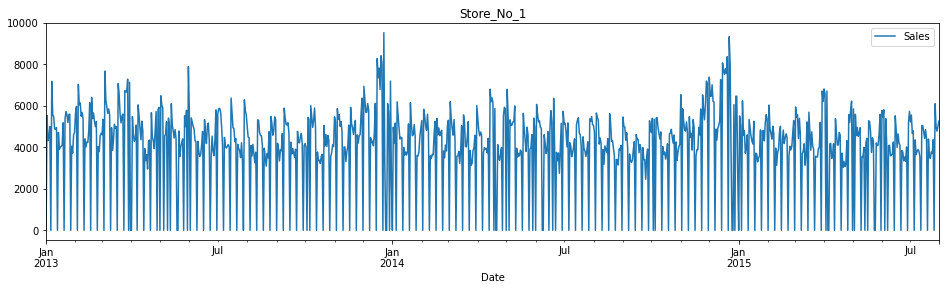

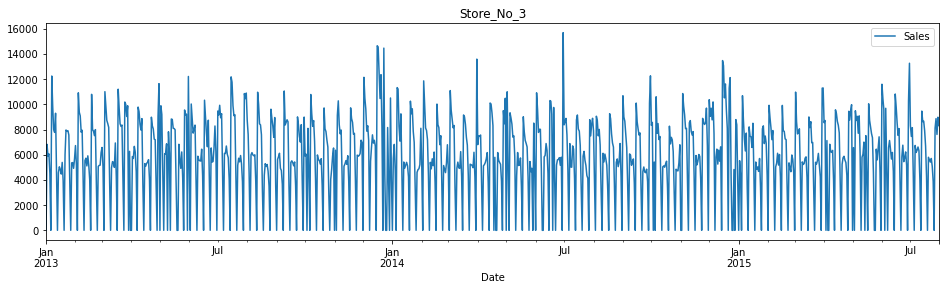

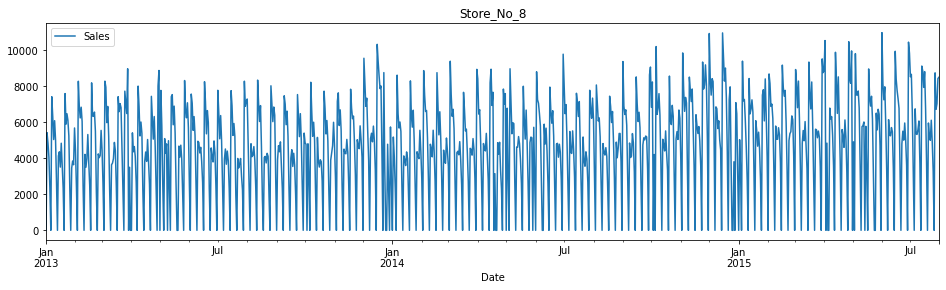

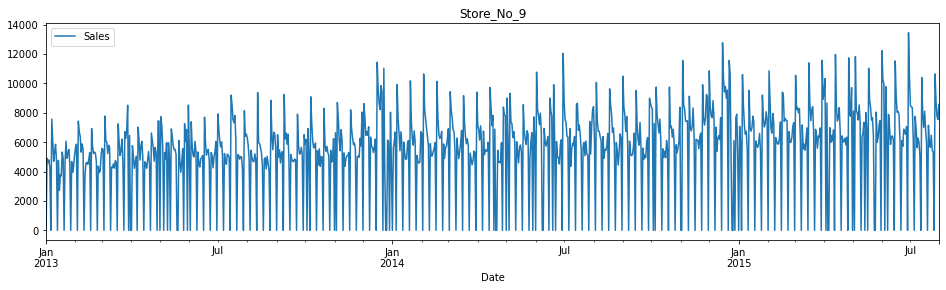

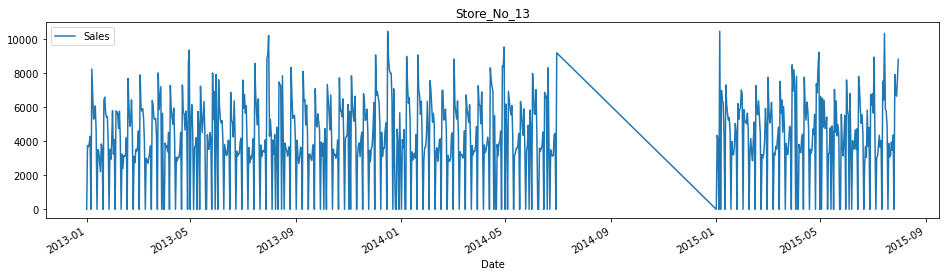

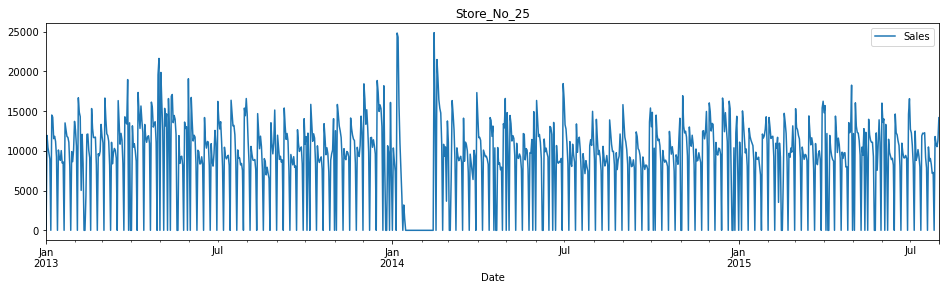

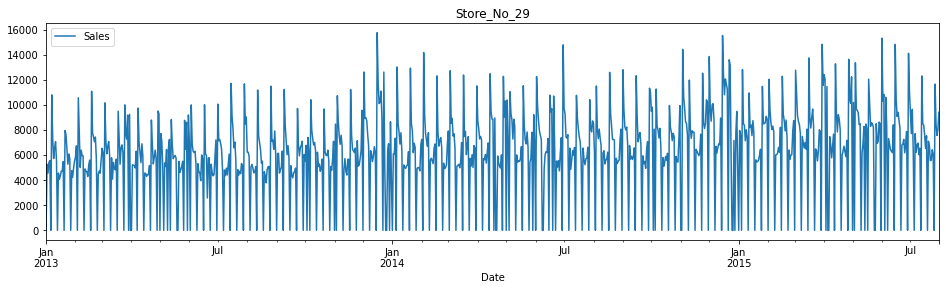

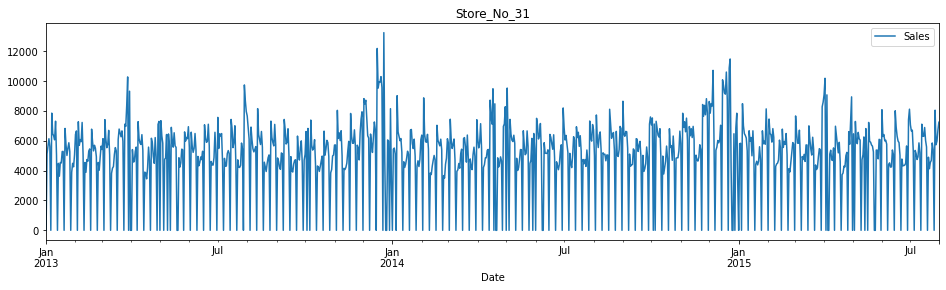

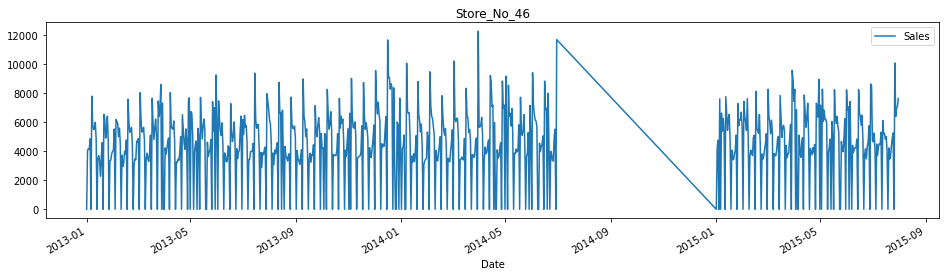

In [163]:
# Let's look at sales of stores in the store list
for i in store_list:
    sub_train.loc[sub_train['Store']==i ,['Date','Sales']].plot(x='Date',y='Sales',title='Store_No_'+str(i),figsize=(16,4))

In [164]:
sub_train.Store.value_counts()

8     942
1     942
9     942
25    942
29    942
3     942
31    942
13    758
46    758
Name: Store, dtype: int64

In [165]:
sub_train[(sub_train.Store==13) & (sub_train.Date > pd.Timestamp(2014,6,1)) & (sub_train.Date < pd.Timestamp(2015,2,1))]

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
201827,13,6,2015-01-31,6805,492,1,0,0,0
202942,13,5,2015-01-30,7004,453,1,1,0,0
204057,13,4,2015-01-29,5963,416,1,1,0,0
205172,13,3,2015-01-28,5847,393,1,1,0,0
206287,13,2,2015-01-27,5285,365,1,1,0,0
207402,13,1,2015-01-26,6208,442,1,1,0,0
208517,13,7,2015-01-25,0,0,0,0,0,0
209632,13,6,2015-01-24,4585,362,1,0,0,0
210747,13,5,2015-01-23,5044,345,1,0,0,0
211862,13,4,2015-01-22,3695,281,1,0,0,0


In [166]:
sub_train[(sub_train.Store==25) & (sub_train.Date > pd.Timestamp(2014,1,1)) & (sub_train.Date < pd.Timestamp(2014,3,1))]

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
544474,25,5,2014-02-28,13764,1782,1,0,0,0
545589,25,4,2014-02-27,3667,635,1,0,0,0
546704,25,3,2014-02-26,10499,1626,1,0,0,0
547819,25,2,2014-02-25,9314,1499,1,0,0,0
548934,25,1,2014-02-24,10824,1687,1,0,0,0
550049,25,7,2014-02-23,0,0,0,0,0,0
551164,25,6,2014-02-22,10903,1466,1,0,0,0
552279,25,5,2014-02-21,14765,1960,1,1,0,0
553394,25,4,2014-02-20,15356,2117,1,1,0,0
554509,25,3,2014-02-19,16406,2105,1,1,0,0


In [167]:
sub_train[(sub_train.Store==46) & (sub_train.Date > pd.Timestamp(2014,6,1)) & (sub_train.Date < pd.Timestamp(2015,2,1))]

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
201860,46,6,2015-01-31,5593,693,1,0,0,0
202975,46,5,2015-01-30,6686,721,1,1,0,0
204090,46,4,2015-01-29,6152,688,1,1,0,0
205205,46,3,2015-01-28,6158,662,1,1,0,0
206320,46,2,2015-01-27,5744,666,1,1,0,0
207435,46,1,2015-01-26,7274,794,1,1,0,0
208550,46,7,2015-01-25,0,0,0,0,0,0
209665,46,6,2015-01-24,5097,662,1,0,0,0
210780,46,5,2015-01-23,4036,573,1,0,0,0
211895,46,4,2015-01-22,3827,515,1,0,0,0


### We find that there is a definite gap in the data or the store did not have any sale for some amount of time.
### Since ARIMA / VARMAX models do handle the gap in time series this missing data is not handled explcitly.

## EDA

In [168]:
# Replace NUll values in store data set to zeros
sub_store.fillna(0, inplace=True)

In [169]:
display(sub_train.isnull().sum(),sub_store.isnull().sum())

Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

Store                        0
StoreType                    0
Assortment                   0
CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
PromoInterval                0
dtype: int64

Sales Value at 99th percentile for Store 1 is : 7906.200000000003
Sales Value at 99th percentile for Store 3 is : 12675.760000000013
Sales Value at 99th percentile for Store 8 is : 9997.13999999999
Sales Value at 99th percentile for Store 9 is : 11570.98
Sales Value at 99th percentile for Store 13 is : 9220.8
Sales Value at 99th percentile for Store 25 is : 19141.71
Sales Value at 99th percentile for Store 29 is : 14120.860000000002
Sales Value at 99th percentile for Store 31 is : 10208.299999999996
Sales Value at 99th percentile for Store 46 is : 9555.689999999999


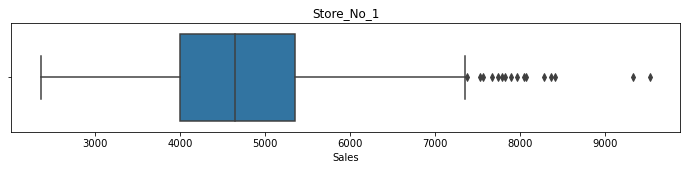

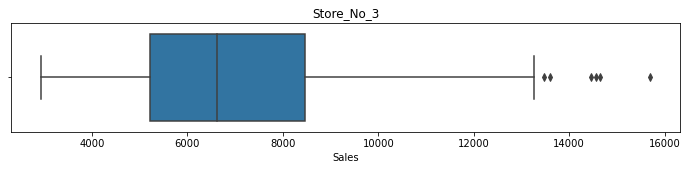

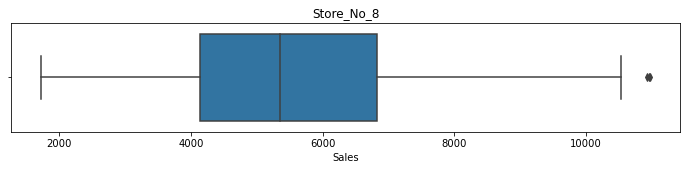

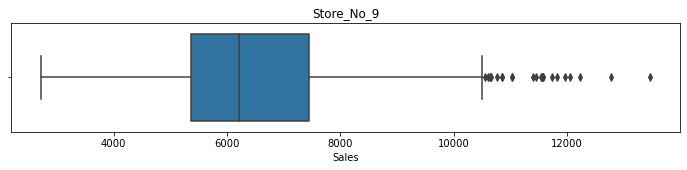

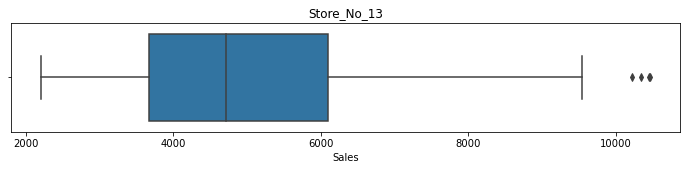

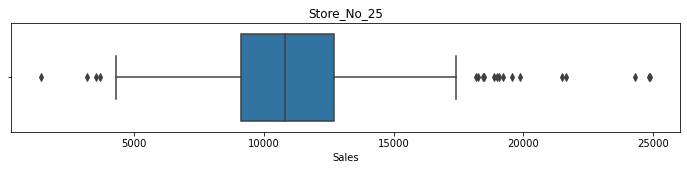

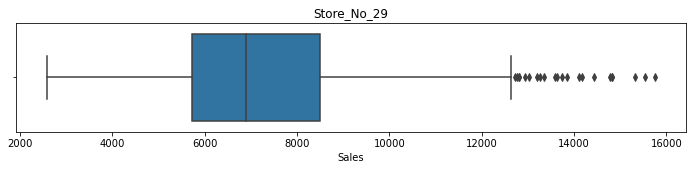

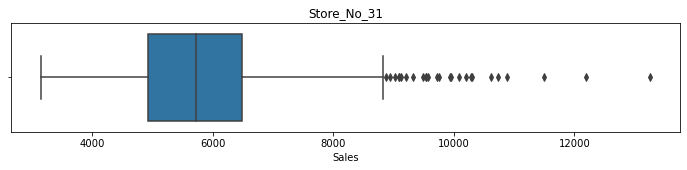

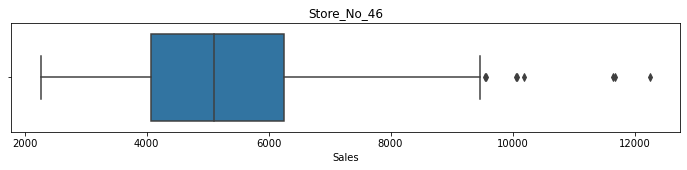

In [170]:
# Let's look at distribution of sales in the store list
import seaborn as sns
for i in store_list:
    salesdata = sub_train[(sub_train.Store==i) & (sub_train.Sales>0)]
    # Find the 99th percentile of sales
    print("Sales Value at 99th percentile for Store "+str(i)+ " is : {0}".format(salesdata.Sales.quantile(0.99)))
    fig = plt.subplots(figsize=(12, 2))
    ax = sns.boxplot(x=salesdata['Sales'],whis=1.5).set(title='Store_No_'+str(i))

In [171]:
final_train_data = pd.DataFrame()
for i in store_list:
    final_train_data = final_train_data.append(sub_train.loc[(sub_train.Store == i) & (sub_train.Sales <= sub_train.Sales.quantile(0.99)),:])

In [172]:
final_train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8028 entries, 0 to 1016140
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Store          8028 non-null   int64         
 1   DayOfWeek      8028 non-null   int64         
 2   Date           8028 non-null   datetime64[ns]
 3   Sales          8028 non-null   int64         
 4   Customers      8028 non-null   int64         
 5   Open           8028 non-null   int64         
 6   Promo          8028 non-null   int64         
 7   StateHoliday   8028 non-null   object        
 8   SchoolHoliday  8028 non-null   int64         
dtypes: datetime64[ns](1), int64(7), object(1)
memory usage: 627.2+ KB


In [173]:
final_train_data.shape

(8028, 9)

In [174]:
# Merge train and store data for further standardization
model_train_data = pd.DataFrame()
model_train_data = pd.merge(final_train_data, sub_store, on='Store')
model_train_data.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [175]:
sub_train.shape

(8110, 9)

In [176]:
mappings = {'0':0, 'a':1, 'b':2, 'c':3, 'd':4}
model_train_data.StoreType.replace(mappings, inplace=True)
model_train_data.Assortment.replace(mappings, inplace=True)
model_train_data.StateHoliday.replace(mappings, inplace=True)


model_train_data['Year'] = model_train_data.Date.dt.year
model_train_data['Month'] = model_train_data.Date.dt.month
model_train_data['Day'] = model_train_data.Date.dt.day
model_train_data['DayOfWeek'] = model_train_data.Date.dt.dayofweek
model_train_data['WeekOfYear'] = model_train_data.Date.dt.weekofyear



model_train_data['CompetitionOpen'] = 12 * (model_train_data.Year - model_train_data.CompetitionOpenSinceYear) +         (model_train_data.Month - model_train_data.CompetitionOpenSinceMonth)
model_train_data['PromoOpen'] = 12 * (model_train_data.Year - model_train_data.Promo2SinceYear) +         (model_train_data.WeekOfYear - model_train_data.Promo2SinceWeek) / 4.0
model_train_data['CompetitionOpen'] = model_train_data.CompetitionOpen.apply(lambda x: x if x > 0 else 0)        
model_train_data['PromoOpen'] = model_train_data.PromoOpen.apply(lambda x: x if x > 0 else 0)



month2str = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun',7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}
model_train_data['monthStr'] = model_train_data.Month.map(month2str)
model_train_data.loc[model_train_data.PromoInterval == 0, 'PromoInterval'] = ''
model_train_data['IsPromoMonth'] = 0

In [177]:
model_train_data.head(20)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,Promo2SinceYear,PromoInterval,Year,Month,Day,WeekOfYear,CompetitionOpen,PromoOpen,monthStr,IsPromoMonth
0,1,4,2015-07-31,5263,555,1,1,0,1,3,...,0.0,,2015,7,31,31,82.0,24187.75,Jul,0
1,1,3,2015-07-30,5020,546,1,1,0,1,3,...,0.0,,2015,7,30,31,82.0,24187.75,Jul,0
2,1,2,2015-07-29,4782,523,1,1,0,1,3,...,0.0,,2015,7,29,31,82.0,24187.75,Jul,0
3,1,1,2015-07-28,5011,560,1,1,0,1,3,...,0.0,,2015,7,28,31,82.0,24187.75,Jul,0
4,1,0,2015-07-27,6102,612,1,1,0,1,3,...,0.0,,2015,7,27,31,82.0,24187.75,Jul,0
5,1,6,2015-07-26,0,0,0,0,0,0,3,...,0.0,,2015,7,26,30,82.0,24187.50,Jul,0
6,1,5,2015-07-25,4364,500,1,0,0,0,3,...,0.0,,2015,7,25,30,82.0,24187.50,Jul,0
7,1,4,2015-07-24,3706,459,1,0,0,0,3,...,0.0,,2015,7,24,30,82.0,24187.50,Jul,0
8,1,3,2015-07-23,3769,503,1,0,0,0,3,...,0.0,,2015,7,23,30,82.0,24187.50,Jul,0
9,1,2,2015-07-22,3464,463,1,0,0,0,3,...,0.0,,2015,7,22,30,82.0,24187.50,Jul,0


In [178]:
for interval in model_train_data.PromoInterval.unique():
    if interval != '':
        for month in interval.split(','):
            model_train_data.loc[(model_train_data.monthStr == month) & (model_train_data.PromoInterval == interval), 'IsPromoMonth'] = 1

In [179]:
model_train_data.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,Promo2SinceYear,PromoInterval,Year,Month,Day,WeekOfYear,CompetitionOpen,PromoOpen,monthStr,IsPromoMonth
0,1,4,2015-07-31,5263,555,1,1,0,1,3,...,0.0,,2015,7,31,31,82.0,24187.75,Jul,0
1,1,3,2015-07-30,5020,546,1,1,0,1,3,...,0.0,,2015,7,30,31,82.0,24187.75,Jul,0
2,1,2,2015-07-29,4782,523,1,1,0,1,3,...,0.0,,2015,7,29,31,82.0,24187.75,Jul,0
3,1,1,2015-07-28,5011,560,1,1,0,1,3,...,0.0,,2015,7,28,31,82.0,24187.75,Jul,0
4,1,0,2015-07-27,6102,612,1,1,0,1,3,...,0.0,,2015,7,27,31,82.0,24187.75,Jul,0


<AxesSubplot:>

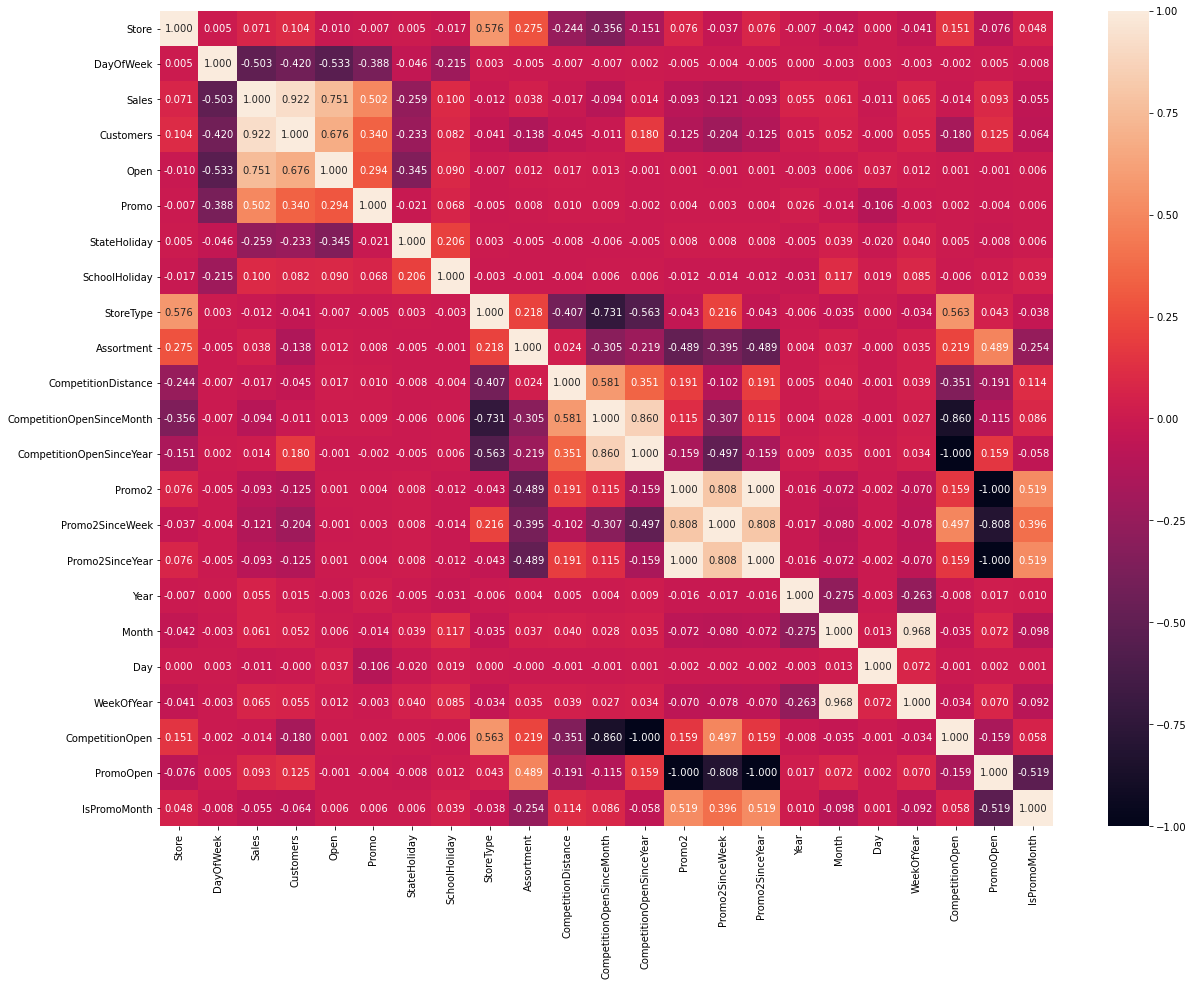

In [180]:
#Check for multicollinearity / feature coorelation by using heatmap:
plot_data=model_train_data[model_train_data['Store']==1]
plt.figure(figsize=[20,15])
sns.heatmap(model_train_data.corr(), annot=True, vmin = -1, vmax = 1, fmt = '.3f')

In [181]:
model_train_data.set_index('Date',inplace=True)

In [182]:
model_train_data.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,...,Promo2SinceYear,PromoInterval,Year,Month,Day,WeekOfYear,CompetitionOpen,PromoOpen,monthStr,IsPromoMonth
Date,,,,,,,,,,,,,,,,,,,,,
2015-07-31,1,4,5263,555,1,1,0,1,3,1,...,0.0,,2015,7,31,31,82.0,24187.75,Jul,0
2015-07-30,1,3,5020,546,1,1,0,1,3,1,...,0.0,,2015,7,30,31,82.0,24187.75,Jul,0
2015-07-29,1,2,4782,523,1,1,0,1,3,1,...,0.0,,2015,7,29,31,82.0,24187.75,Jul,0
2015-07-28,1,1,5011,560,1,1,0,1,3,1,...,0.0,,2015,7,28,31,82.0,24187.75,Jul,0
2015-07-27,1,0,6102,612,1,1,0,1,3,1,...,0.0,,2015,7,27,31,82.0,24187.75,Jul,0


## Time Series Analysis

In [183]:
# Stationarity test
ls=['Sales','Customers','Promo','CompetitionDistance', 'CompetitionOpenSinceMonth','Promo2', 'Promo2SinceWeek','CompetitionOpen','IsPromoMonth']
for j in store_list:
    print ('ADF Result for Store '+ str(j))
    for i in range(len(ls)):
        print('\n\n' + ls[i] + ': ADF test results:')
        result = adfuller(model_train_data[model_train_data['Store']==j][ls[i]])
        print('ADF Statistic: %f' % result[0])
        print('p-value: %f' % result[1])
        print('Critical Values:')
        for key, value in result[4].items():
            if key=='5%':
                print('\t%s: %.3f' % (key, value))

ADF Result for Store 1


Sales: ADF test results:
ADF Statistic: -4.374784
p-value: 0.000329
Critical Values:
	5%: -2.865


Customers: ADF test results:
ADF Statistic: -3.647407
p-value: 0.004917
Critical Values:
	5%: -2.865


Promo: ADF test results:
ADF Statistic: -8.151481
p-value: 0.000000
Critical Values:
	5%: -2.865


CompetitionDistance: ADF test results:
ADF Statistic: nan
p-value: nan
Critical Values:
	5%: -2.865


CompetitionOpenSinceMonth: ADF test results:
ADF Statistic: nan
p-value: nan
Critical Values:
	5%: -2.865


Promo2: ADF test results:
ADF Statistic: nan
p-value: nan
Critical Values:
	5%: -2.865


Promo2SinceWeek: ADF test results:
ADF Statistic: nan
p-value: nan
Critical Values:
	5%: -2.865


CompetitionOpen: ADF test results:
ADF Statistic: -0.260857
p-value: 0.930868
Critical Values:
	5%: -2.865


IsPromoMonth: ADF test results:
ADF Statistic: nan
p-value: nan
Critical Values:
	5%: -2.865
ADF Result for Store 3


Sales: ADF test results:
ADF Statistic: -5.819612


In [184]:
model_train_data.index

DatetimeIndex(['2015-07-31', '2015-07-30', '2015-07-29', '2015-07-28',
               '2015-07-27', '2015-07-26', '2015-07-25', '2015-07-24',
               '2015-07-23', '2015-07-22',
               ...
               '2013-01-10', '2013-01-09', '2013-01-08', '2013-01-07',
               '2013-01-06', '2013-01-05', '2013-01-04', '2013-01-03',
               '2013-01-02', '2013-01-01'],
              dtype='datetime64[ns]', name='Date', length=8028, freq=None)

### Inference: p-Values suggest the we would have to reject the null hypothesis and hence that the time series stationary

In [185]:
# Plotting time series chart for Sales
def decomp_plot(inp,col):
    fig = plt.figure(figsize=(20, 3))
    inp.plot()
    plt.xlabel('Date')
    plt.ylabel(col)
    plt.title('For {}'.format(col))
    plt.show()

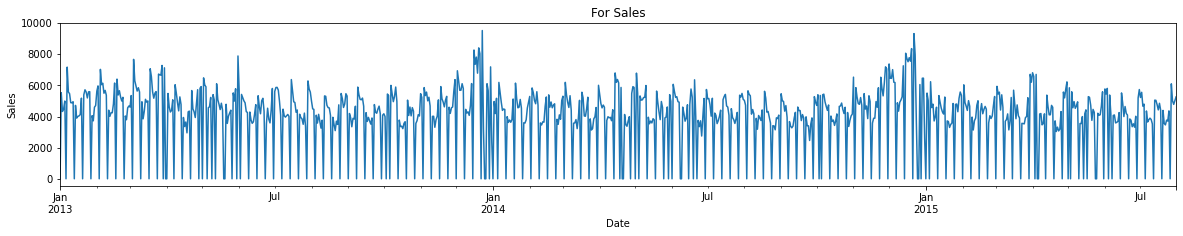

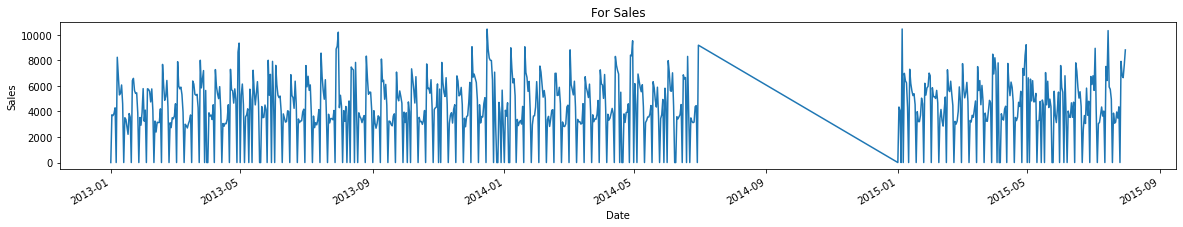

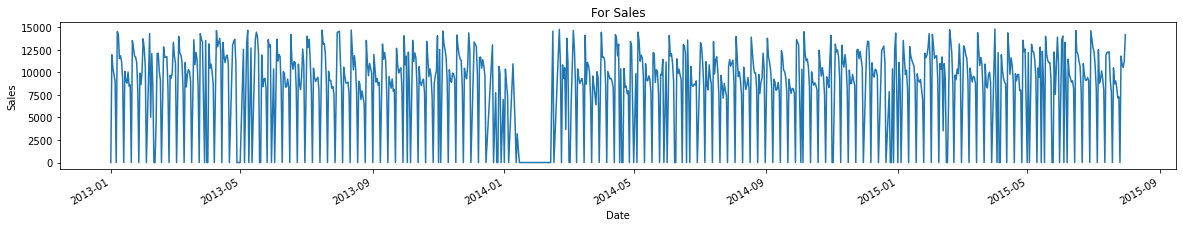

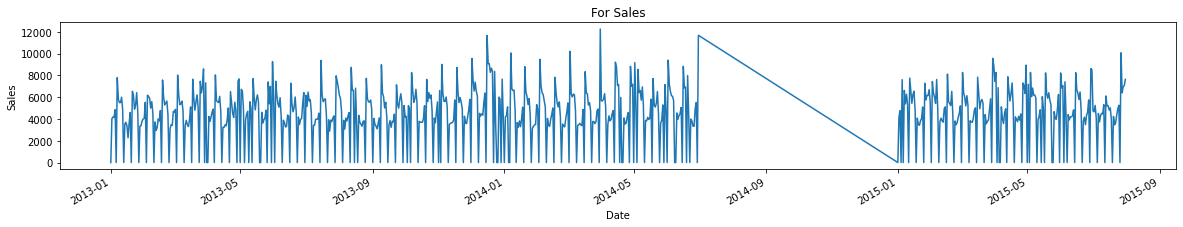

In [186]:
# Look at the timeseries for some stores:
decomp_plot(model_train_data[model_train_data['Store']==1].Sales,'Sales')

decomp_plot(model_train_data[model_train_data['Store']==13].Sales,'Sales')

decomp_plot(model_train_data[model_train_data['Store']==25].Sales,'Sales')

decomp_plot(model_train_data[model_train_data['Store']==46].Sales,'Sales')

#### ACF and PACF plots

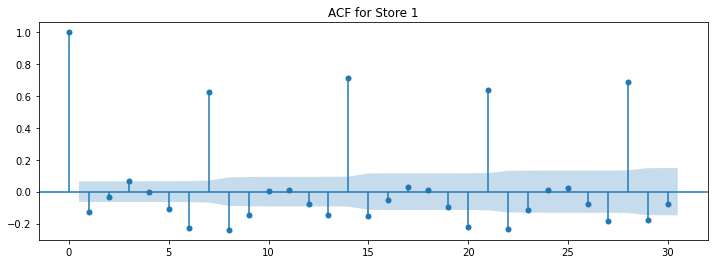

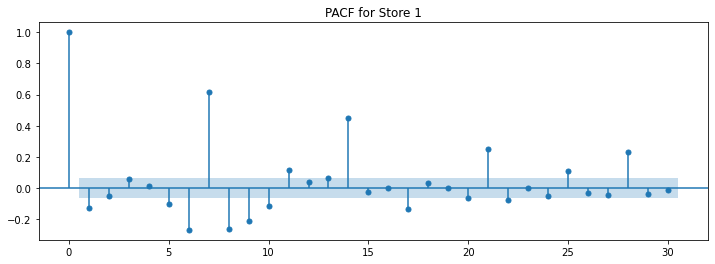

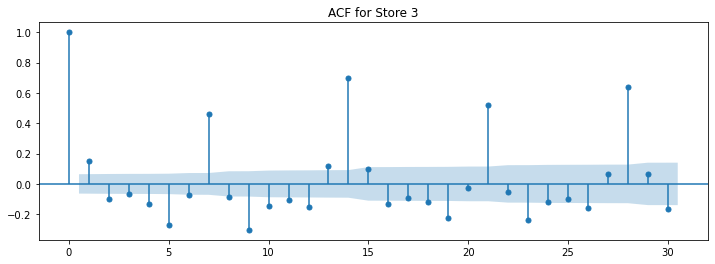

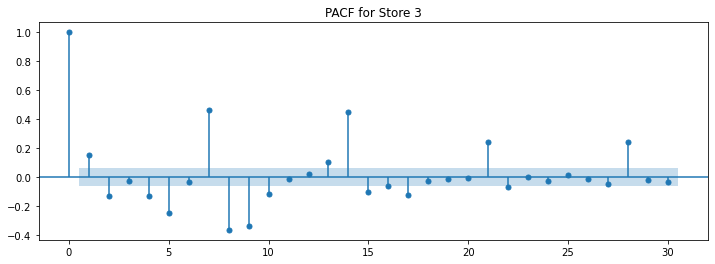

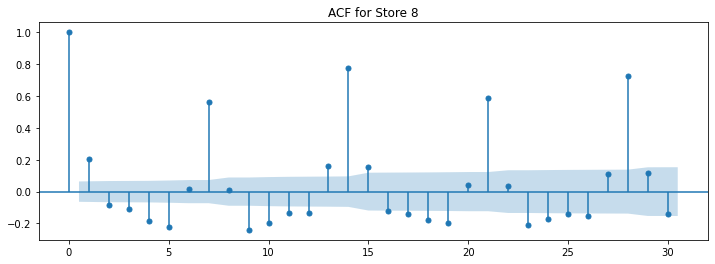

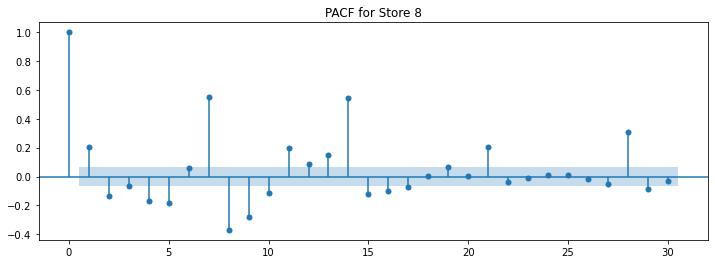

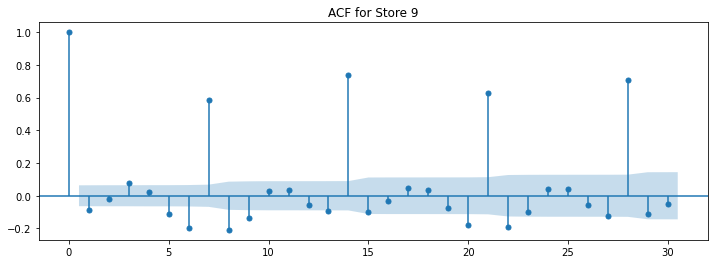

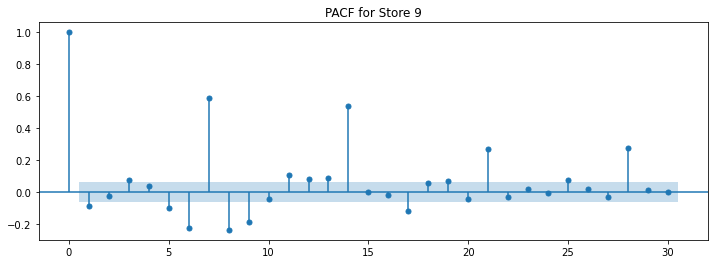

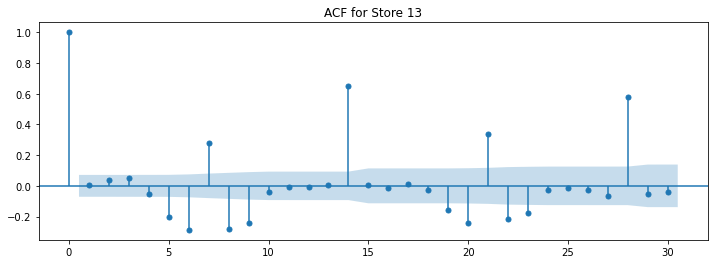

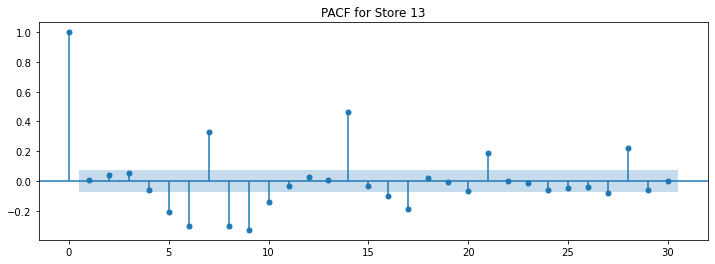

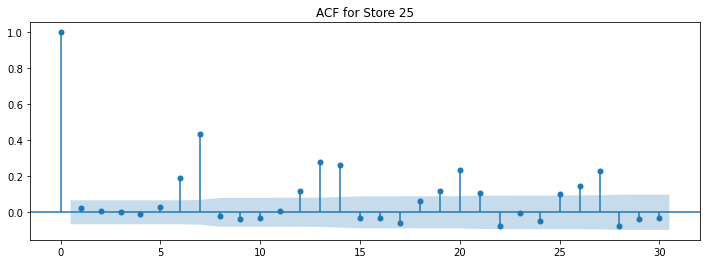

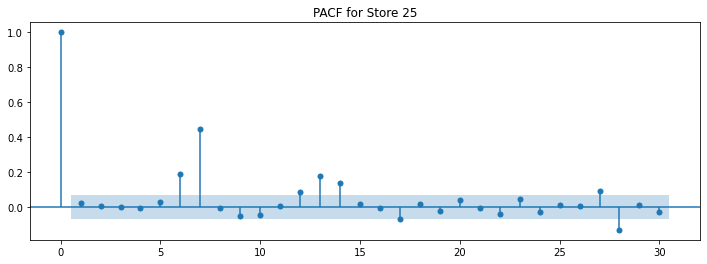

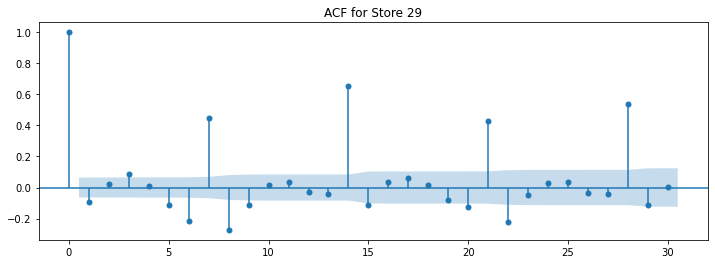

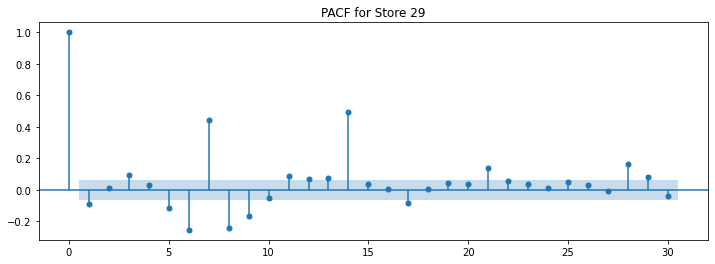

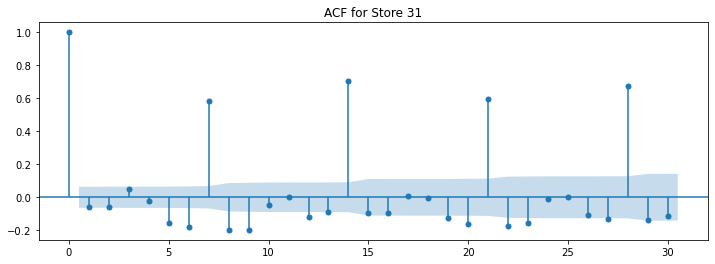

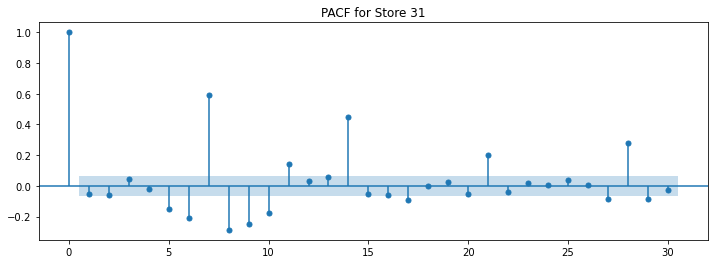

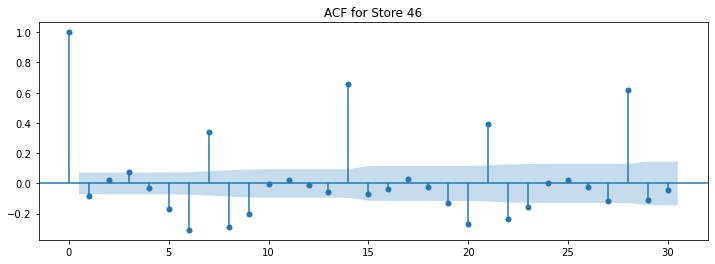

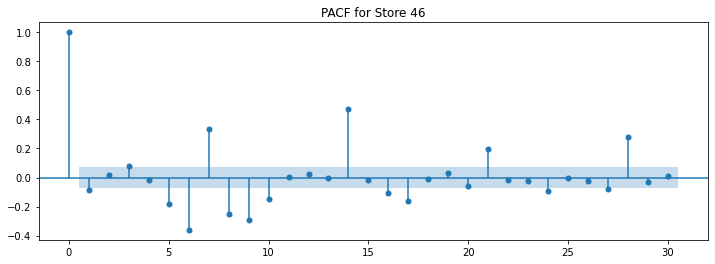

In [187]:
for i in store_list:
    sample_train = model_train_data[model_train_data['Store']==i]
    plt.figure(figsize=(12,4))
    plot_acf(sample_train.Sales, ax=plt.gca(), lags = 30, title = 'ACF for Store '+str(i))
    plt.show()
    plt.figure(figsize=(12,4))
    plot_pacf(sample_train.Sales, ax=plt.gca(), lags = 30, title = 'PACF for Store '+str(i))
    plt.show()

## Model Building (VARMAX)

#### Model for Store 1

                           Statespace Model Results                           
Dep. Variable:     ['Sales', 'Promo']   No. Observations:                  547
Model:                        VARX(1)   Log Likelihood                 734.759
Date:                Mon, 20 Jun 2022   AIC                          -1451.518
Time:                        18:12:23   BIC                          -1412.778
Sample:                             0   HQIC                         -1436.375
                                - 547                                         
Covariance Type:                  opg                                         
Ljung-Box (L1) (Q):            60.36, 0.76   Jarque-Bera (JB):         45.23, 74.16
Prob(Q):                        0.00, 0.38   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         0.76, 0.95   Skew:                      0.63, -0.74
Prob(H) (two-sided):            0.06, 0.75   Kurtosis:                   3.63, 4.02
                            Resu

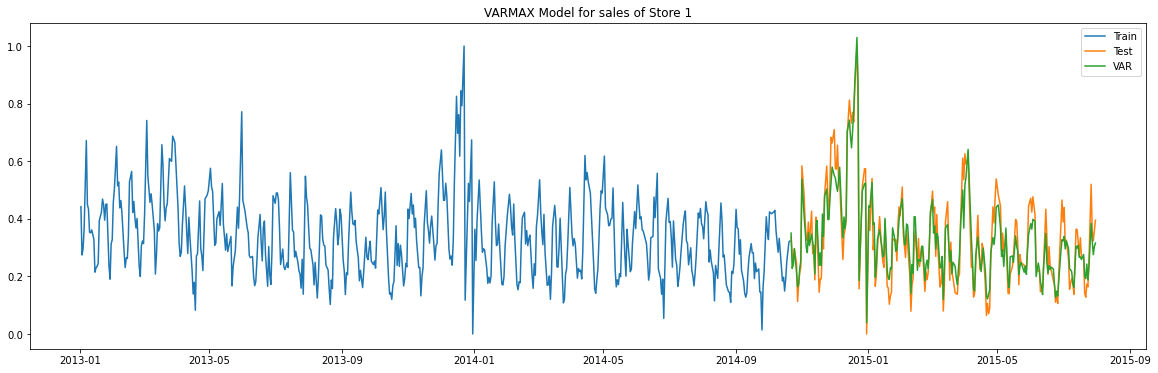

In [188]:
model_data = pd.DataFrame()
ErrVal=pd.DataFrame()
model_data = model_train_data[model_train_data['Store']==1 & (model_train_data['Sales']>0)]
model_data.sort_index(inplace=True)
train_len=round(len(model_data)*0.7)
train_data=model_data[:train_len]
test_data=model_data[train_len:]

# Standardize the variable for that store

scaler = MinMaxScaler()
train_data[['Sales','Customers']]=scaler.fit_transform(train_data[['Sales','Customers']])


# VARMAX Model
exog = train_data[['Customers']]
depvar = train_data[['Sales', 'Promo']].astype(float)
mod = sm.tsa.VARMAX(depvar, order=(1,0),trend='n', exog=exog)
res = mod.fit(maxiter=1000, disp=False)
print(res.summary())

# Predict for the store
test_data[['Sales','Customers']]=scaler.fit_transform(test_data[['Sales','Customers']])
exog_test=test_data[['Customers']]
varmax_fc = mod.fit().predict(start=train_len,end=len(model_data)-1,exog=exog_test)

varmax_fc.reset_index(inplace=True)
varmax_fc.columns=['ind','FC_Sales','FC_Promo']

result = test_data.copy()
result.reset_index(inplace=True)
rslt = pd.concat([result[['Date','Sales','Customers']], varmax_fc],axis=1)
rslt.set_index('Date',inplace=True)

#Plot the Predictions
plt.figure(figsize=(20,6))
plt.plot(train_data['Sales'], label='Train')
plt.plot(test_data['Sales'], label='Test')
plt.plot(rslt['FC_Sales'], label='VAR')
plt.legend(loc='best')
plt.title('VARMAX Model for sales of Store 1')
plt.show()

In [189]:
print ('Performance check for Store 1')
# Root Mean Square Error (RMSE)
rmse = np.sqrt(mean_squared_error(rslt['Sales'], rslt['FC_Sales'])).round(2)

# Mean Absolute Percentage Error
num=np.abs(rslt['Sales']-rslt['FC_Sales'])
den=rslt['FC_Sales']
mape = np.round(np.mean(num/den)*100,2)

ErrVal = pd.DataFrame({'Store':1, 'MAPE': [mape], 'RMSE': [rmse]})
ErrVal = ErrVal[['Store', 'RMSE', 'MAPE']]
ErrVal

Performance check for Store 1


,Store,RMSE,MAPE
0,1,0.06,15.6


### Cointegration - Johansen Test

In [190]:
def joh_output(res):
    output = pd.DataFrame([res.lr2,res.lr1],
                          index=['max_eig_stat',"trace_stat"])
    print(output.T,'\n')
    print("Critical values(90%, 95%, 99%) of max_eig_stat\n",res.cvm,'\n')
    print("Critical values(90%, 95%, 99%) of trace_stat\n",res.cvt,'\n')

In [191]:
joh_model1 = coint_johansen(model_data[['Sales','Customers','Promo']],-1,1) # k_ar_diff +1 = K
joh_output(joh_model1)

   max_eig_stat  trace_stat
0    220.802303  393.807463
1    171.124481  173.005160
2      1.880678    1.880678 

Critical values(90%, 95%, 99%) of max_eig_stat
 [[15.7175 17.7961 22.2519]
 [ 9.4748 11.2246 15.0923]
 [ 2.9762  4.1296  6.9406]] 

Critical values(90%, 95%, 99%) of trace_stat
 [[21.7781 24.2761 29.5147]
 [10.4741 12.3212 16.364 ]
 [ 2.9762  4.1296  6.9406]] 



### Inference:We have the rank of Johassen test as 2 which means that the time series are stationary and do not seem to be co-integratied

#### Model for Store 3

                           Statespace Model Results                           
Dep. Variable:     ['Sales', 'Promo']   No. Observations:                  545
Model:                        VARX(1)   Log Likelihood                 866.764
Date:                Mon, 20 Jun 2022   AIC                          -1715.527
Time:                        18:12:27   BIC                          -1676.820
Sample:                             0   HQIC                         -1700.395
                                - 545                                         
Covariance Type:                  opg                                         
Ljung-Box (L1) (Q):           150.11, 0.04   Jarque-Bera (JB):         63.33, 51.96
Prob(Q):                        0.00, 0.85   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         1.04, 1.37   Skew:                      0.76, -0.50
Prob(H) (two-sided):            0.78, 0.03   Kurtosis:                   3.70, 4.14
                            Resu

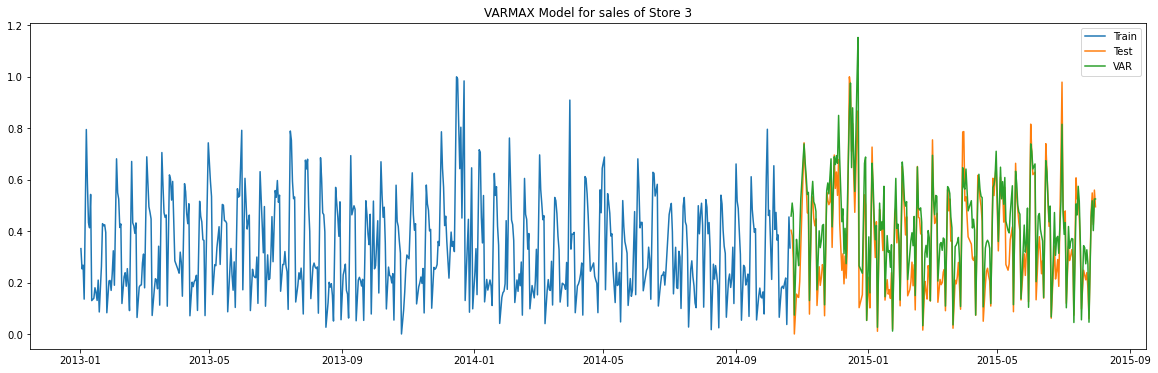

In [192]:
model_data = pd.DataFrame()
model_data = model_train_data[(model_train_data['Store'] == 3) & (model_train_data['Sales']>0)]
model_data.sort_index(inplace=True)
train_len=round(len(model_data)*0.7)
train_data=model_data[:train_len]
test_data=model_data[train_len:]

# Standardize the variable for that store

scaler = MinMaxScaler()
train_data[['Sales','Customers']]=scaler.fit_transform(train_data[['Sales','Customers']])


# VARMAX Model
exog = train_data[['Customers']]
depvar = train_data[['Sales', 'Promo']].astype(float)
mod = sm.tsa.VARMAX(depvar, order=(1,0),trend='n', exog=exog)
res = mod.fit(maxiter=1000, disp=False)
print(res.summary())

# Predict for the store
test_data[['Sales','Customers']]=scaler.fit_transform(test_data[['Sales','Customers']])
exog_test=test_data[['Customers']]
varmax_fc = mod.fit().predict(start=train_len,end=len(model_data)-1,exog=exog_test)

varmax_fc.reset_index(inplace=True)
varmax_fc.columns=['ind','FC_Sales','FC_Promo']

result = test_data.copy()
result.reset_index(inplace=True)
rslt = pd.concat([result[['Date','Sales','Customers']], varmax_fc],axis=1)
rslt.set_index('Date',inplace=True)

#Plot the Predictions
plt.figure(figsize=(20,6))
plt.plot(train_data['Sales'], label='Train')
plt.plot(test_data['Sales'], label='Test')
plt.plot(rslt['FC_Sales'], label='VAR')
plt.legend(loc='best')
plt.title('VARMAX Model for sales of Store 3')
plt.show()

In [193]:
print ('Performance check for Store 3')
# Root Mean Square Error (RMSE)
rmse = np.sqrt(mean_squared_error(rslt['Sales'], rslt['FC_Sales'])).round(2)

# Mean Absolute Percentage Error
num=np.abs(rslt['Sales']-rslt['FC_Sales'])
den=rslt['FC_Sales']
mape = np.round(np.mean(num/den)*100,2)

TempErrVal = pd.DataFrame({'Store':3, 'MAPE': [mape], 'RMSE': [rmse]})
ErrVal = pd.concat([TempErrVal,ErrVal])
ErrVal = ErrVal[['Store', 'RMSE', 'MAPE']]
ErrVal

Performance check for Store 3


,Store,RMSE,MAPE
0,3,0.10,21.82
0,1,0.06,15.60


#### Model for Store 8

                           Statespace Model Results                           
Dep. Variable:     ['Sales', 'Promo']   No. Observations:                  549
Model:                        VARX(1)   Log Likelihood                 796.808
Date:                Mon, 20 Jun 2022   AIC                          -1575.617
Time:                        18:12:31   BIC                          -1536.844
Sample:                             0   HQIC                         -1560.464
                                - 549                                         
Covariance Type:                  opg                                         
Ljung-Box (L1) (Q):           104.72, 1.50   Jarque-Bera (JB):         15.99, 60.68
Prob(Q):                        0.00, 0.22   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         1.21, 1.06   Skew:                      0.41, -0.74
Prob(H) (two-sided):            0.19, 0.69   Kurtosis:                   3.13, 3.69
                            Resu

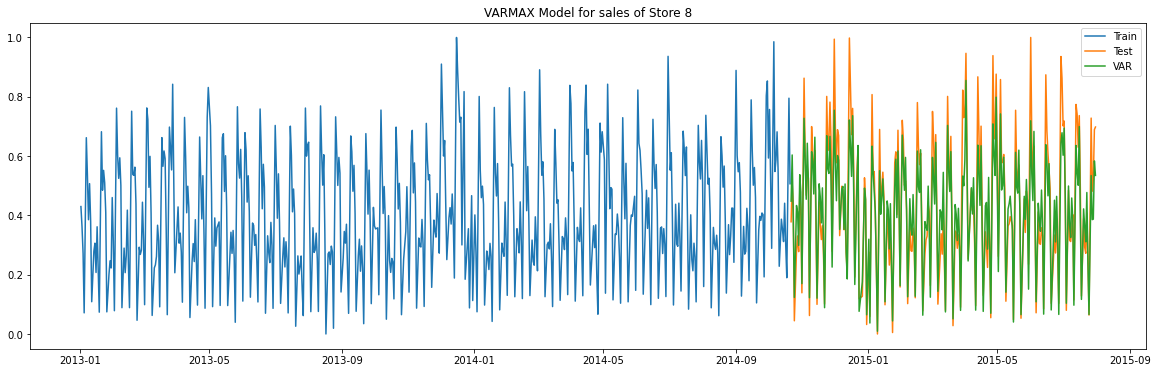

In [194]:
model_data = pd.DataFrame()
model_data = model_train_data[(model_train_data['Store'] == 8) & (model_train_data['Sales']>0)]
model_data.sort_index(inplace=True)
train_len=round(len(model_data)*0.7)
train_data=model_data[:train_len]
test_data=model_data[train_len:]

# Standardize the variable for that store

scaler = MinMaxScaler()
train_data[['Sales','Customers']]=scaler.fit_transform(train_data[['Sales','Customers']])


# VARMAX Model
exog = train_data[['Customers']]
depvar = train_data[['Sales', 'Promo']].astype(float)
mod = sm.tsa.VARMAX(depvar, order=(1,0),trend='n', exog=exog)
res = mod.fit(maxiter=1000, disp=False)
print(res.summary())

# Predict for the store
test_data[['Sales','Customers']]=scaler.fit_transform(test_data[['Sales','Customers']])
exog_test=test_data[['Customers']]
varmax_fc = mod.fit().predict(start=train_len,end=len(model_data)-1,exog=exog_test)

varmax_fc.reset_index(inplace=True)
varmax_fc.columns=['ind','FC_Sales','FC_Promo']

result = test_data.copy()
result.reset_index(inplace=True)
rslt = pd.concat([result[['Date','Sales','Customers']], varmax_fc],axis=1)
rslt.set_index('Date',inplace=True)

#Plot the Predictions
plt.figure(figsize=(20,6))
plt.plot(train_data['Sales'], label='Train')
plt.plot(test_data['Sales'], label='Test')
plt.plot(rslt['FC_Sales'], label='VAR')
plt.legend(loc='best')
plt.title('VARMAX Model for sales of Store 8')
plt.show()

In [195]:
print ('Performance check for Store 8')
# Root Mean Square Error (RMSE)
rmse = np.sqrt(mean_squared_error(rslt['Sales'], rslt['FC_Sales'])).round(2)

# Mean Absolute Percentage Error
num=np.abs(rslt['Sales']-rslt['FC_Sales'])
den=rslt['FC_Sales']
mape = np.round(np.mean(num/den)*100,2)

TempErrVal = pd.DataFrame({'Store':8, 'MAPE': [mape], 'RMSE': [rmse]})
ErrVal = pd.concat([TempErrVal,ErrVal])
ErrVal = ErrVal[['Store', 'RMSE', 'MAPE']]
ErrVal

Performance check for Store 8


,Store,RMSE,MAPE
0,8,0.09,17.99
0,3,0.10,21.82
0,1,0.06,15.60


#### Model for Store 9

                           Statespace Model Results                           
Dep. Variable:     ['Sales', 'Promo']   No. Observations:                  545
Model:                        VARX(1)   Log Likelihood                 834.456
Date:                Mon, 20 Jun 2022   AIC                          -1650.911
Time:                        18:12:36   BIC                          -1612.204
Sample:                             0   HQIC                         -1635.779
                                - 545                                         
Covariance Type:                  opg                                         
Ljung-Box (L1) (Q):            76.01, 7.51   Jarque-Bera (JB):         22.60, 59.41
Prob(Q):                        0.00, 0.01   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         1.68, 0.83   Skew:                      0.38, -0.70
Prob(H) (two-sided):            0.00, 0.21   Kurtosis:                   3.64, 3.82
                            Resu

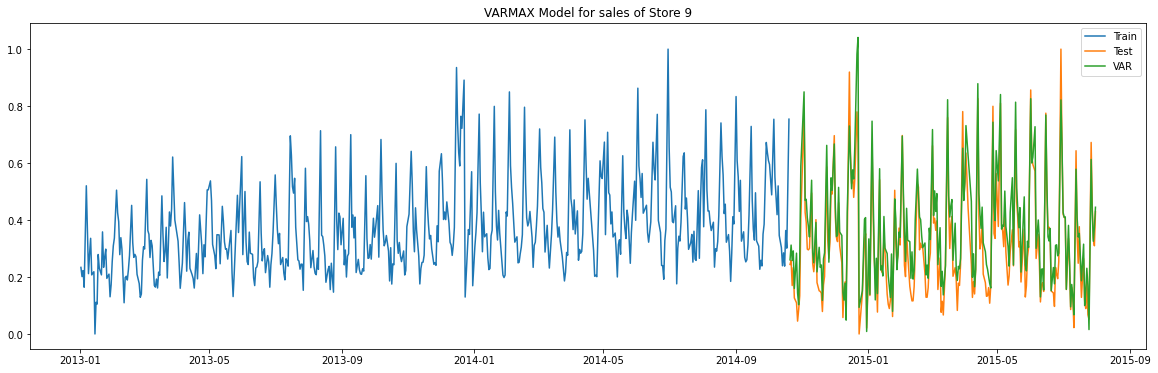

In [196]:
model_data = pd.DataFrame()
model_data = model_train_data[(model_train_data['Store'] == 9) & (model_train_data['Sales']>0)]
model_data.sort_index(inplace=True)
train_len=round(len(model_data)*0.7)
train_data=model_data[:train_len]
test_data=model_data[train_len:]

# Standardize the variable for that store

scaler = MinMaxScaler()
train_data[['Sales','Customers']]=scaler.fit_transform(train_data[['Sales','Customers']])


# VARMAX Model
exog = train_data[['Customers']]
depvar = train_data[['Sales', 'Promo']].astype(float)
mod = sm.tsa.VARMAX(depvar, order=(1,0),trend='n', exog=exog)
res = mod.fit(maxiter=1000, disp=False)
print(res.summary())

# Predict for the store
test_data[['Sales','Customers']]=scaler.fit_transform(test_data[['Sales','Customers']])
exog_test=test_data[['Customers']]
varmax_fc = mod.fit().predict(start=train_len,end=len(model_data)-1,exog=exog_test)

varmax_fc.reset_index(inplace=True)
varmax_fc.columns=['ind','FC_Sales','FC_Promo']

result = test_data.copy()
result.reset_index(inplace=True)
rslt = pd.concat([result[['Date','Sales','Customers']], varmax_fc],axis=1)
rslt.set_index('Date',inplace=True)

#Plot the Predictions
plt.figure(figsize=(20,6))
plt.plot(train_data['Sales'], label='Train')
plt.plot(test_data['Sales'], label='Test')
plt.plot(rslt['FC_Sales'], label='VAR')
plt.legend(loc='best')
plt.title('VARMAX Model for sales of Store 9')
plt.show()

In [197]:
print ('Performance check for Store 9')
# Root Mean Square Error (RMSE)
rmse = np.sqrt(mean_squared_error(rslt['Sales'], rslt['FC_Sales'])).round(2)

# Mean Absolute Percentage Error
num=np.abs(rslt['Sales']-rslt['FC_Sales'])
den=rslt['FC_Sales']
mape = np.round(np.mean(num/den)*100,2)

TempErrVal = pd.DataFrame({'Store':9, 'MAPE': [mape], 'RMSE': [rmse]})
ErrVal = pd.concat([TempErrVal,ErrVal])
ErrVal = ErrVal[['Store', 'RMSE', 'MAPE']]
ErrVal

Performance check for Store 9


,Store,RMSE,MAPE
0,9,0.08,22.43
0,8,0.09,17.99
0,3,0.10,21.82
0,1,0.06,15.60


#### Model for Store 13

                           Statespace Model Results                           
Dep. Variable:     ['Sales', 'Promo']   No. Observations:                  435
Model:                        VARX(1)   Log Likelihood                 670.301
Date:                Mon, 20 Jun 2022   AIC                          -1322.602
Time:                        18:12:39   BIC                          -1285.924
Sample:                             0   HQIC                         -1308.126
                                - 435                                         
Covariance Type:                  opg                                         
Ljung-Box (L1) (Q):            75.08, 0.00   Jarque-Bera (JB):         55.55, 18.27
Prob(Q):                        0.00, 0.99   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         1.24, 0.96   Skew:                      0.73, -0.46
Prob(H) (two-sided):            0.19, 0.81   Kurtosis:                   3.98, 3.38
                            Resu

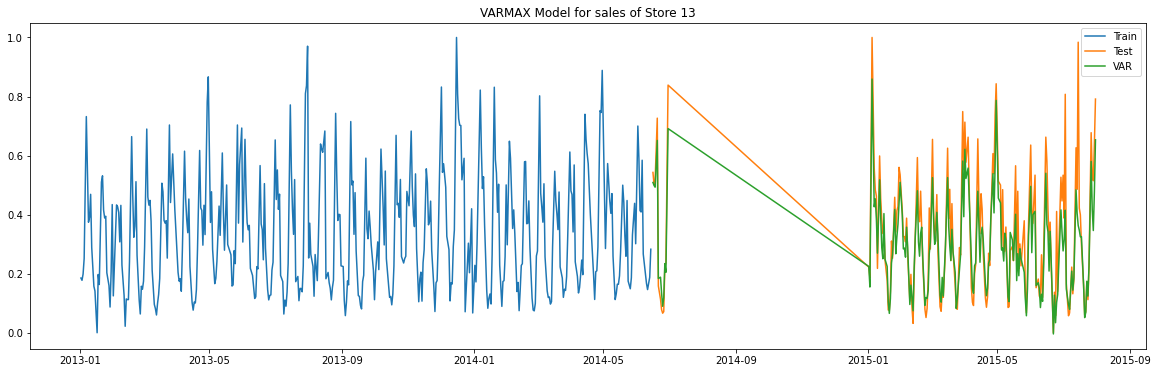

In [198]:
model_data = pd.DataFrame()
model_data = model_train_data[(model_train_data['Store'] == 13) & (model_train_data['Sales']>0)]
model_data.sort_index(inplace=True)
train_len=round(len(model_data)*0.7)
train_data=model_data[:train_len]
test_data=model_data[train_len:]

# Standardize the variable for that store

scaler = MinMaxScaler()
train_data[['Sales','Customers']]=scaler.fit_transform(train_data[['Sales','Customers']])


# VARMAX Model
exog = train_data[['Customers']]
depvar = train_data[['Sales', 'Promo']].astype(float)
mod = sm.tsa.VARMAX(depvar, order=(1,0),trend='n', exog=exog)
res = mod.fit(maxiter=1000, disp=False)
print(res.summary())

# Predict for the store
test_data[['Sales','Customers']]=scaler.fit_transform(test_data[['Sales','Customers']])
exog_test=test_data[['Customers']]
varmax_fc = mod.fit().predict(start=train_len,end=len(model_data)-1,exog=exog_test)

varmax_fc.reset_index(inplace=True)
varmax_fc.columns=['ind','FC_Sales','FC_Promo']

result = test_data.copy()
result.reset_index(inplace=True)
rslt = pd.concat([result[['Date','Sales','Customers']], varmax_fc],axis=1)
rslt.set_index('Date',inplace=True)

#Plot the Predictions
plt.figure(figsize=(20,6))
plt.plot(train_data['Sales'], label='Train')
plt.plot(test_data['Sales'], label='Test')
plt.plot(rslt['FC_Sales'], label='VAR')
plt.legend(loc='best')
plt.title('VARMAX Model for sales of Store 13')
plt.show()

In [199]:
print ('Performance check for Store 13')
# Root Mean Square Error (RMSE)
rmse = np.sqrt(mean_squared_error(rslt['Sales'], rslt['FC_Sales'])).round(2)

# Mean Absolute Percentage Error
num=np.abs(rslt['Sales']-rslt['FC_Sales'])
den=rslt['FC_Sales']
mape = np.round(np.mean(num/den)*100,2)

TempErrVal = pd.DataFrame({'Store':13, 'MAPE': [mape], 'RMSE': [rmse]})
ErrVal = pd.concat([TempErrVal,ErrVal])
ErrVal = ErrVal[['Store', 'RMSE', 'MAPE']]
ErrVal

Performance check for Store 13


,Store,RMSE,MAPE
0,13,0.10,23.62
0,9,0.08,22.43
0,8,0.09,17.99
0,3,0.10,21.82
0,1,0.06,15.60


#### Model for Store 25

                           Statespace Model Results                           
Dep. Variable:     ['Sales', 'Promo']   No. Observations:                  472
Model:                        VARX(1)   Log Likelihood                 656.635
Date:                Mon, 20 Jun 2022   AIC                          -1295.270
Time:                        18:12:44   BIC                          -1257.857
Sample:                             0   HQIC                         -1280.553
                                - 472                                         
Covariance Type:                  opg                                         
Ljung-Box (L1) (Q):           139.02, 3.43   Jarque-Bera (JB):         25.80, 29.15
Prob(Q):                        0.00, 0.06   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         1.15, 0.90   Skew:                      0.57, -0.48
Prob(H) (two-sided):            0.39, 0.53   Kurtosis:                   3.13, 3.74
                            Resu

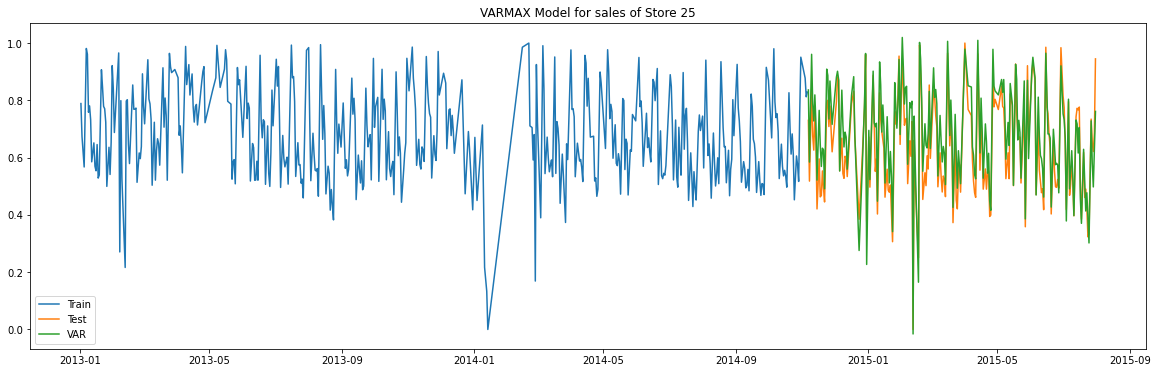

In [200]:
model_data = pd.DataFrame()
model_data = model_train_data[(model_train_data['Store'] == 25) & (model_train_data['Sales']>0)]
model_data.sort_index(inplace=True)
train_len=round(len(model_data)*0.7)
train_data=model_data[:train_len]
test_data=model_data[train_len:]

# Standardize the variable for that store

scaler = MinMaxScaler()
train_data[['Sales','Customers']]=scaler.fit_transform(train_data[['Sales','Customers']])


# VARMAX Model
exog = train_data[['Customers']]
depvar = train_data[['Sales', 'Promo']].astype(float)
mod = sm.tsa.VARMAX(depvar, order=(1,0),trend='n', exog=exog)
res = mod.fit(maxiter=1000, disp=False)
print(res.summary())

# Predict for the store
test_data[['Sales','Customers']]=scaler.fit_transform(test_data[['Sales','Customers']])
exog_test=test_data[['Customers']]
varmax_fc = mod.fit().predict(start=train_len,end=len(model_data)-1,exog=exog_test)

varmax_fc.reset_index(inplace=True)
varmax_fc.columns=['ind','FC_Sales','FC_Promo']

result = test_data.copy()
result.reset_index(inplace=True)
rslt = pd.concat([result[['Date','Sales','Customers']], varmax_fc],axis=1)
rslt.set_index('Date',inplace=True)

#Plot the Predictions
plt.figure(figsize=(20,6))
plt.plot(train_data['Sales'], label='Train')
plt.plot(test_data['Sales'], label='Test')
plt.plot(rslt['FC_Sales'], label='VAR')
plt.legend(loc='best')
plt.title('VARMAX Model for sales of Store 25')
plt.show()

In [201]:
print ('Performance check for Store 25')
# Root Mean Square Error (RMSE)
rmse = np.sqrt(mean_squared_error(rslt['Sales'], rslt['FC_Sales'])).round(2)

# Mean Absolute Percentage Error
num=np.abs(rslt['Sales']-rslt['FC_Sales'])
den=rslt['FC_Sales']
mape = np.round(np.mean(num/den)*100,2)

TempErrVal = pd.DataFrame({'Store':25, 'MAPE': [mape], 'RMSE': [rmse]})
ErrVal = pd.concat([TempErrVal,ErrVal])
ErrVal = ErrVal[['Store', 'RMSE', 'MAPE']]
ErrVal

Performance check for Store 25


,Store,RMSE,MAPE
0,25,0.08,9.91
0,13,0.10,23.62
0,9,0.08,22.43
0,8,0.09,17.99
0,3,0.10,21.82
0,1,0.06,15.60


#### Model for Store 29

                           Statespace Model Results                           
Dep. Variable:     ['Sales', 'Promo']   No. Observations:                  542
Model:                        VARX(1)   Log Likelihood                 837.126
Date:                Mon, 20 Jun 2022   AIC                          -1656.253
Time:                        18:12:48   BIC                          -1617.595
Sample:                             0   HQIC                         -1641.137
                                - 542                                         
Covariance Type:                  opg                                         
Ljung-Box (L1) (Q):           139.40, 0.01   Jarque-Bera (JB):       103.96, 129.95
Prob(Q):                        0.00, 0.92   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         1.35, 0.84   Skew:                      0.95, -1.03
Prob(H) (two-sided):            0.04, 0.25   Kurtosis:                   4.00, 4.24
                            Resu

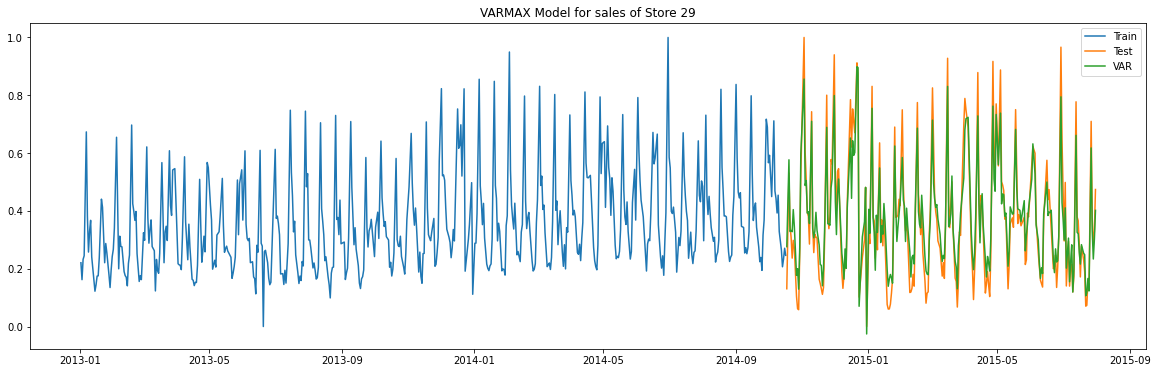

In [202]:
model_data = pd.DataFrame()
model_data = model_train_data[(model_train_data['Store'] == 29) & (model_train_data['Sales']>0)]
model_data.sort_index(inplace=True)
train_len=round(len(model_data)*0.7)
train_data=model_data[:train_len]
test_data=model_data[train_len:]

# Standardize the variable for that store

scaler = MinMaxScaler()
train_data[['Sales','Customers']]=scaler.fit_transform(train_data[['Sales','Customers']])


# VARMAX Model
exog = train_data[['Customers']]
depvar = train_data[['Sales', 'Promo']].astype(float)
mod = sm.tsa.VARMAX(depvar, order=(1,0),trend='n', exog=exog)
res = mod.fit(maxiter=1000, disp=False)
print(res.summary())

# Predict for the store
test_data[['Sales','Customers']]=scaler.fit_transform(test_data[['Sales','Customers']])
exog_test=test_data[['Customers']]
varmax_fc = mod.fit().predict(start=train_len,end=len(model_data)-1,exog=exog_test)

varmax_fc.reset_index(inplace=True)
varmax_fc.columns=['ind','FC_Sales','FC_Promo']

result = test_data.copy()
result.reset_index(inplace=True)
rslt = pd.concat([result[['Date','Sales','Customers']], varmax_fc],axis=1)
rslt.set_index('Date',inplace=True)

#Plot the Predictions
plt.figure(figsize=(20,6))
plt.plot(train_data['Sales'], label='Train')
plt.plot(test_data['Sales'], label='Test')
plt.plot(rslt['FC_Sales'], label='VAR')
plt.legend(loc='best')
plt.title('VARMAX Model for sales of Store 29')
plt.show()

In [203]:
print ('Performance check for Store 29')
# Root Mean Square Error (RMSE)
rmse = np.sqrt(mean_squared_error(rslt['Sales'], rslt['FC_Sales'])).round(2)

# Mean Absolute Percentage Error
num=np.abs(rslt['Sales']-rslt['FC_Sales'])
den=rslt['FC_Sales']
mape = np.round(np.mean(num/den)*100,2)

TempErrVal = pd.DataFrame({'Store':29, 'MAPE': [mape], 'RMSE': [rmse]})
ErrVal = pd.concat([TempErrVal,ErrVal])
ErrVal = ErrVal[['Store', 'RMSE', 'MAPE']]
ErrVal

Performance check for Store 29


,Store,RMSE,MAPE
0,29,0.07,17.22
0,25,0.08,9.91
0,13,0.10,23.62
0,9,0.08,22.43
0,8,0.09,17.99
0,3,0.10,21.82
0,1,0.06,15.60


#### Model for Store 31

                           Statespace Model Results                           
Dep. Variable:     ['Sales', 'Promo']   No. Observations:                  549
Model:                        VARX(1)   Log Likelihood                 855.906
Date:                Mon, 20 Jun 2022   AIC                          -1693.812
Time:                        18:12:53   BIC                          -1655.039
Sample:                             0   HQIC                         -1678.659
                                - 549                                         
Covariance Type:                  opg                                         
Ljung-Box (L1) (Q):            67.85, 7.59   Jarque-Bera (JB):        147.07, 25.45
Prob(Q):                        0.00, 0.01   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         0.83, 0.87   Skew:                      0.74, -0.42
Prob(H) (two-sided):            0.21, 0.33   Kurtosis:                   5.06, 3.65
                            Resu

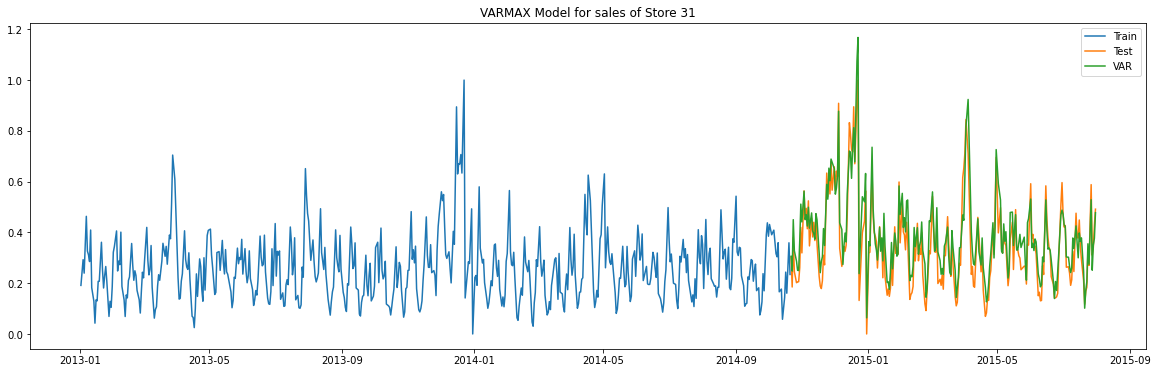

In [204]:
model_data = pd.DataFrame()
model_data = model_train_data[(model_train_data['Store'] == 31) & (model_train_data['Sales']>0)]
model_data.sort_index(inplace=True)
train_len=round(len(model_data)*0.7)
train_data=model_data[:train_len]
test_data=model_data[train_len:]

# Standardize the variable for that store

scaler = MinMaxScaler()
train_data[['Sales','Customers']]=scaler.fit_transform(train_data[['Sales','Customers']])


# VARMAX Model
exog = train_data[['Customers']]
depvar = train_data[['Sales', 'Promo']].astype(float)
mod = sm.tsa.VARMAX(depvar, order=(1,0),trend='n', exog=exog)
res = mod.fit(maxiter=1000, disp=False)
print(res.summary())

# Predict for the store
test_data[['Sales','Customers']]=scaler.fit_transform(test_data[['Sales','Customers']])
exog_test=test_data[['Customers']]
varmax_fc = mod.fit().predict(start=train_len,end=len(model_data)-1,exog=exog_test)

varmax_fc.reset_index(inplace=True)
varmax_fc.columns=['ind','FC_Sales','FC_Promo']

result = test_data.copy()
result.reset_index(inplace=True)
rslt = pd.concat([result[['Date','Sales','Customers']], varmax_fc],axis=1)
rslt.set_index('Date',inplace=True)

#Plot the Predictions
plt.figure(figsize=(20,6))
plt.plot(train_data['Sales'], label='Train')
plt.plot(test_data['Sales'], label='Test')
plt.plot(rslt['FC_Sales'], label='VAR')
plt.legend(loc='best')
plt.title('VARMAX Model for sales of Store 31')
plt.show()

In [205]:
print ('Performance check for Store 31')
# Root Mean Square Error (RMSE)
rmse = np.sqrt(mean_squared_error(rslt['Sales'], rslt['FC_Sales'])).round(2)

# Mean Absolute Percentage Error
num=np.abs(rslt['Sales']-rslt['FC_Sales'])
den=rslt['FC_Sales']
mape = np.round(np.mean(num/den)*100,2)

TempErrVal = pd.DataFrame({'Store':31, 'MAPE': [mape], 'RMSE': [rmse]})
ErrVal = pd.concat([TempErrVal,ErrVal])
ErrVal = ErrVal[['Store', 'RMSE', 'MAPE']]
ErrVal

Performance check for Store 31


,Store,RMSE,MAPE
0,31,0.07,15.43
0,29,0.07,17.22
0,25,0.08,9.91
0,13,0.10,23.62
0,9,0.08,22.43
0,8,0.09,17.99
0,3,0.10,21.82
0,1,0.06,15.60


#### Model for store 46

                           Statespace Model Results                           
Dep. Variable:     ['Sales', 'Promo']   No. Observations:                  435
Model:                        VARX(1)   Log Likelihood                 670.147
Date:                Mon, 20 Jun 2022   AIC                          -1322.294
Time:                        18:12:57   BIC                          -1285.616
Sample:                             0   HQIC                         -1307.818
                                - 435                                         
Covariance Type:                  opg                                         
Ljung-Box (L1) (Q):            35.10, 0.06   Jarque-Bera (JB):       230.29, 118.11
Prob(Q):                        0.00, 0.81   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         1.88, 1.08   Skew:                      1.06, -0.87
Prob(H) (two-sided):            0.00, 0.66   Kurtosis:                   5.87, 4.87
                            Resu

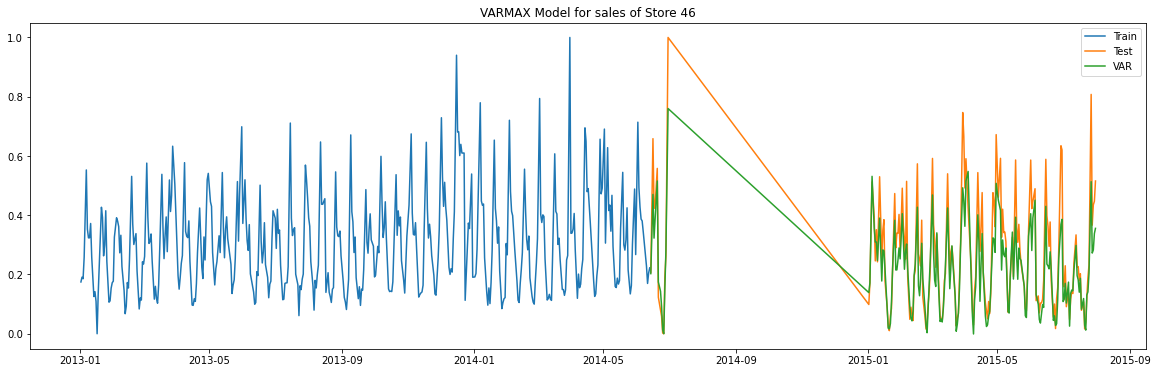

In [206]:
model_data = pd.DataFrame()
model_data = model_train_data[(model_train_data['Store'] == 46) & (model_train_data['Sales']>0)]
model_data.sort_index(inplace=True)
train_len=round(len(model_data)*0.7)
train_data=model_data[:train_len]
test_data=model_data[train_len:]

# Standardize the variable for that store

scaler = MinMaxScaler()
train_data[['Sales','Customers']]=scaler.fit_transform(train_data[['Sales','Customers']])


# VARMAX Model
exog = train_data[['Customers']]
depvar = train_data[['Sales', 'Promo']].astype(float)
mod = sm.tsa.VARMAX(depvar, order=(1,0),trend='n', exog=exog)
res = mod.fit(maxiter=1000, disp=False)
print(res.summary())

# Predict for the store
test_data[['Sales','Customers']]=scaler.fit_transform(test_data[['Sales','Customers']])
exog_test=test_data[['Customers']]
varmax_fc = mod.fit().predict(start=train_len,end=len(model_data)-1,exog=exog_test)

varmax_fc.reset_index(inplace=True)
varmax_fc.columns=['ind','FC_Sales','FC_Promo']

result = test_data.copy()
result.reset_index(inplace=True)
rslt = pd.concat([result[['Date','Sales','Customers']], varmax_fc],axis=1)
rslt.set_index('Date',inplace=True)

#Plot the Predictions
plt.figure(figsize=(20,6))
plt.plot(train_data['Sales'], label='Train')
plt.plot(test_data['Sales'], label='Test')
plt.plot(rslt['FC_Sales'], label='VAR')
plt.legend(loc='best')
plt.title('VARMAX Model for sales of Store 46')
plt.show()

In [207]:
print ('Performance check for Store 46')
# Root Mean Square Error (RMSE)
rmse = np.sqrt(mean_squared_error(rslt['Sales'], rslt['FC_Sales'])).round(2)

# Mean Absolute Percentage Error
num=np.abs(rslt['Sales']-rslt['FC_Sales'])
den=rslt['FC_Sales']
mape = np.round(np.mean(num/den)*100,2)

TempErrVal = pd.DataFrame({'Store':46, 'MAPE': [mape], 'RMSE': [rmse]})
ErrVal = pd.concat([TempErrVal,ErrVal])
ErrVal = ErrVal[['Store', 'RMSE', 'MAPE']]
ErrVal

Performance check for Store 46


,Store,RMSE,MAPE
0,46,0.09,20.50
0,31,0.07,15.43
0,29,0.07,17.22
0,25,0.08,9.91
0,13,0.10,23.62
0,9,0.08,22.43
0,8,0.09,17.99
0,3,0.10,21.82
0,1,0.06,15.60
